
# Permutation Importance with Multicollinear or Correlated Features

In this example, we compute the
:func:`~sklearn.inspection.permutation_importance` of the features to a trained
:class:`~sklearn.ensemble.RandomForestClassifier` using the
`breast_cancer_dataset`. The model can easily get about 97% accuracy on a
test dataset. Because this dataset contains multicollinear features, the
permutation importance shows that none of the features are important, in
contradiction with the high test accuracy.

We demo a possible approach to handling multicollinearity, which consists of
hierarchical clustering on the features' Spearman rank-order correlations,
picking a threshold, and keeping a single feature from each cluster.

<div class="alert alert-info"><h4>Note</h4><p>See also
    `sphx_glr_auto_examples_inspection_plot_permutation_importance.py`</p></div>


## Random Forest Feature Importance on Breast Cancer Data

First, we define a function to ease the plotting:



In [4]:
from sklearn.inspection import permutation_importance


def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

We then train a :class:`~sklearn.ensemble.RandomForestClassifier` on the
`breast_cancer_dataset` and evaluate its accuracy on a test set:



In [5]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print(f"Baseline accuracy on test data: {clf.score(X_test, y_test):.2}")

Baseline accuracy on test data: 0.97


Next, we plot the tree based feature importance and the permutation
importance. The permutation importance is calculated on the training set to
show how much the model relies on each feature during training.



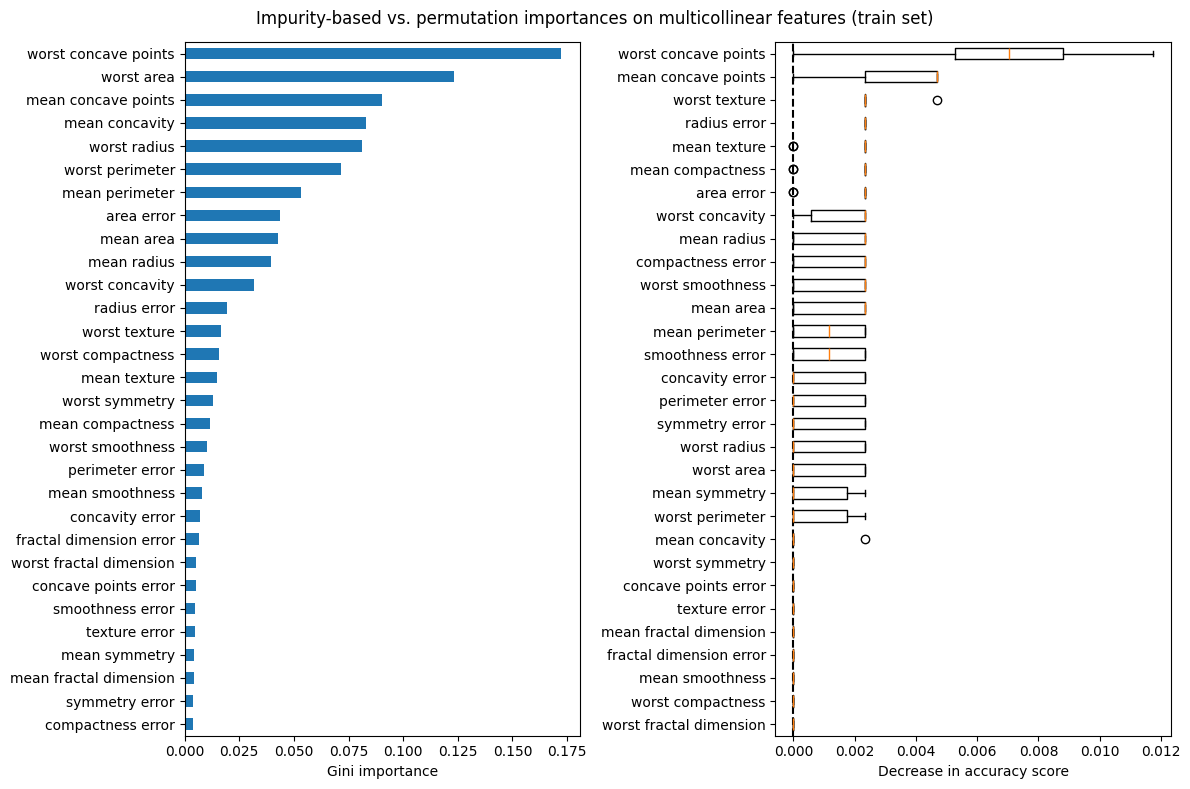

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

mdi_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
mdi_importances.sort_values().plot.barh(ax=ax1)
ax1.set_xlabel("Gini importance")
plot_permutation_importance(clf, X_train, y_train, ax2)
ax2.set_xlabel("Decrease in accuracy score")
fig.suptitle(
    "Impurity-based vs. permutation importances on multicollinear features (train set)"
)
_ = fig.tight_layout()

The plot on the left shows the Gini importance of the model. As the
scikit-learn implementation of
:class:`~sklearn.ensemble.RandomForestClassifier` uses a random subsets of
$\sqrt{n_\text{features}}$ features at each split, it is able to dilute
the dominance of any single correlated feature. As a result, the individual
feature importance may be distributed more evenly among the correlated
features. Since the features have large cardinality and the classifier is
non-overfitted, we can relatively trust those values.

The permutation importance on the right plot shows that permuting a feature
drops the accuracy by at most `0.012`, which would suggest that none of the
features are important. This is in contradiction with the high test accuracy
computed as baseline: some feature must be important.

Similarly, the change in accuracy score computed on the test set appears to be
driven by chance:



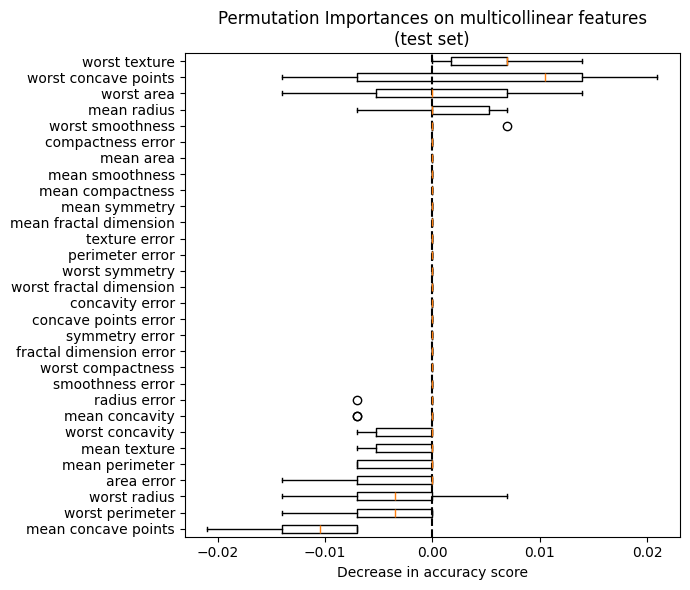

In [7]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(clf, X_test, y_test, ax)
ax.set_title("Permutation Importances on multicollinear features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
_ = ax.figure.tight_layout()

Nevertheless, one can still compute a meaningful permutation importance in the
presence of correlated features, as demonstrated in the following section.

## Handling Multicollinear Features
When features are collinear, permuting one feature has little effect on the
models performance because it can get the same information from a correlated
feature. Note that this is not the case for all predictive models and depends
on their underlying implementation.

One way to handle multicollinear features is by performing hierarchical
clustering on the Spearman rank-order correlations, picking a threshold, and
keeping a single feature from each cluster. First, we plot a heatmap of the
correlated features:



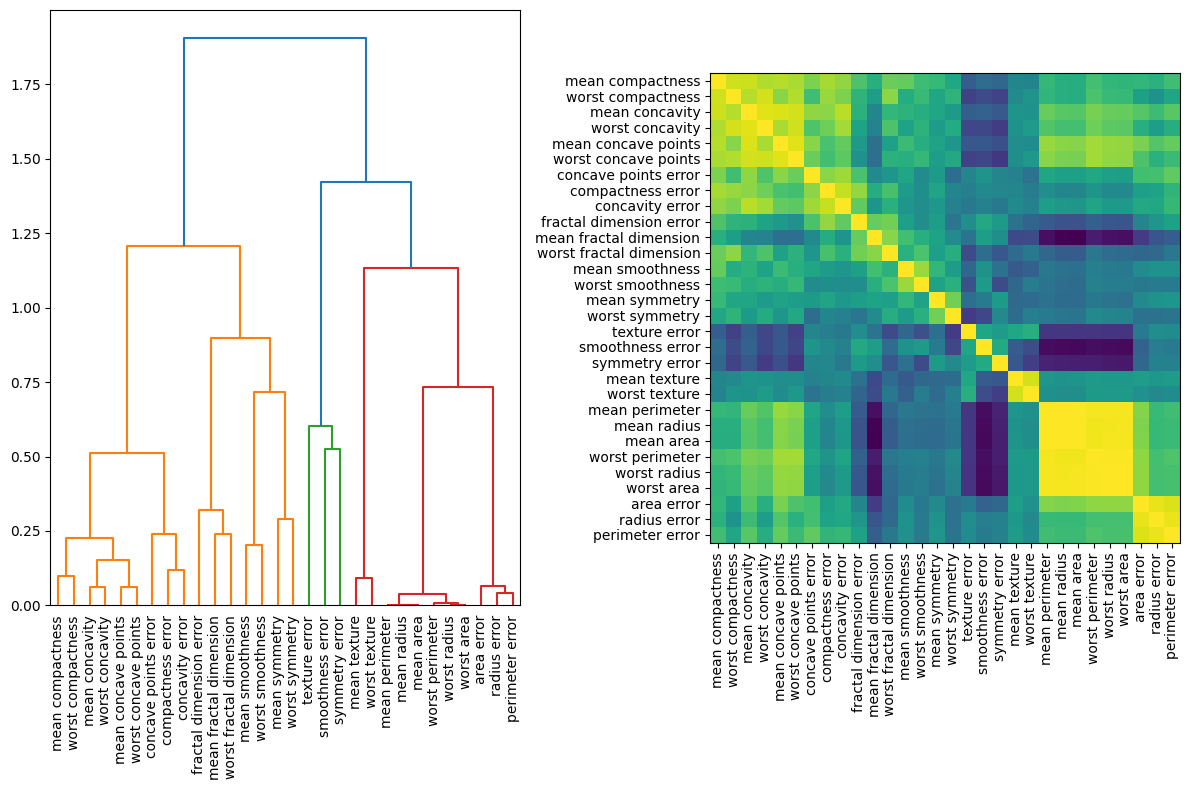

In [14]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

Next, we manually pick a threshold by visual inspection of the dendrogram to
group our features into clusters and choose a feature from each cluster to
keep, select those features from our dataset, and train a new random forest.
The test accuracy of the new random forest did not change much compared to the
random forest trained on the complete dataset.



In [39]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 0.5, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X.columns[selected_features]

X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print(
    "Baseline accuracy on test data with features removed:"
    f" {clf_sel.score(X_test_sel, y_test):.2}"
)

Baseline accuracy on test data with features removed: 0.94


We can finally explore the permutation importance of the selected subset of
features:



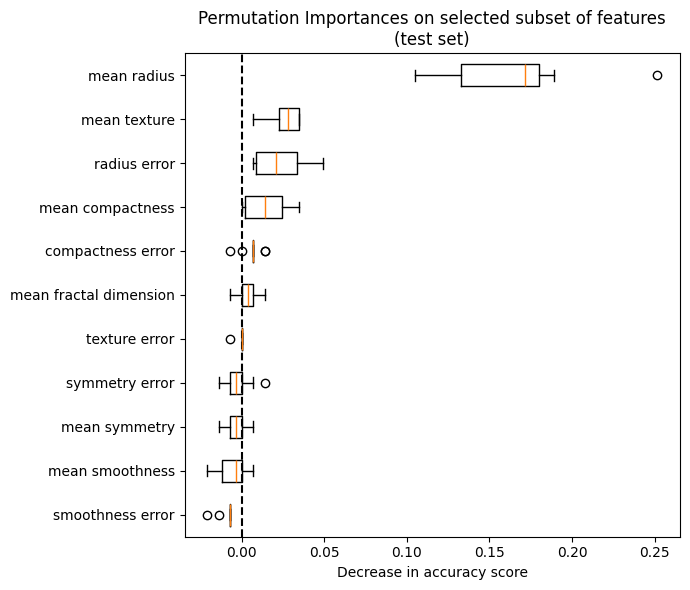

In [40]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(clf_sel, X_test_sel, y_test, ax)
ax.set_title("Permutation Importances on selected subset of features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()